This script runs ARIMA models (p=d=q=range(0,5)) on 15min interval data.

# TODO

1. Run ARIMA on 5min and 15min data.
2. Run ARIMAX.

# Note

1. Data is not interpolated. If df does not contain NaN's then matplotlib will represent missing data with a line.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 5]
# %matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_folder = 'data'
site = 'power_ciee'

# Import data

In [3]:
df_raw = pd.read_csv(data_folder + '/' + site + '.csv', index_col=[0], parse_dates=True)
df_raw = df_raw[(df_raw.index < '2019-04-01')]
df_raw.head()

,power
datetime,
2018-01-01 00:00:03.773218+00:00,2240.0
2018-01-01 00:00:06.892048+00:00,2240.0
2018-01-01 00:00:17.600902+00:00,2240.0
2018-01-01 00:00:20.849818+00:00,2240.0
2018-01-01 00:00:25.001628+00:00,2240.0


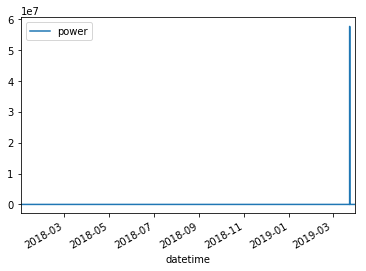

In [4]:
df_raw.plot()

# Clean data

Resample data to 1min interval, remove outliers and drop NaN's.

In [5]:
df_processed = df_raw.resample('15T').mean()
df_processed = df_processed[df_processed['power'] < 30000]
df_processed = df_processed[(np.abs(stats.zscore(df_processed)) < float(3)).all(axis=1)]
df_processed.dropna(inplace=True)
df_processed.head()

,power
datetime,
2018-01-01 00:00:00+00:00,2213.766234
2018-01-01 00:15:00+00:00,2187.284768
2018-01-01 00:30:00+00:00,2544.736842
2018-01-01 00:45:00+00:00,2467.532468
2018-01-01 01:00:00+00:00,2465.695364


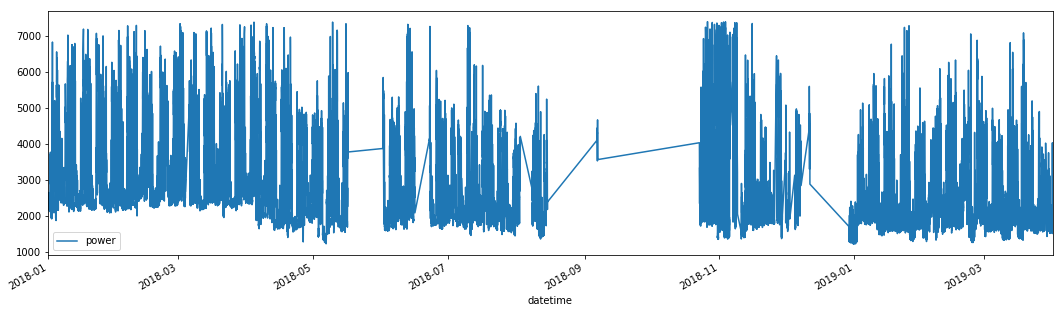

In [6]:
df_processed.plot(figsize=(18,5))

# Check for stationarity

## ACF

High autocorrelation shows that the data is non-stationary

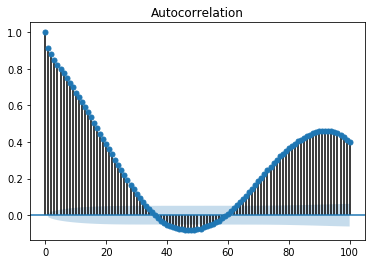

In [7]:
fig1 = plot_acf(df_processed['power'], lags=100)

## Dickey Fuller Test

In [8]:
result = adfuller(df_processed['power'], autolag='AIC')
output = pd.Series(result[0:4], index=['Test Statistics', 'p-value', '#Lags Used',
                                      '#Observations Used'])
for key, value in result[4].items():
    output['Critical Value (%s)' % key] = value
    
output

Test Statistics        -1.865210e+01
p-value                 2.050413e-30
#Lags Used              4.900000e+01
#Observations Used      2.966400e+04
Critical Value (1%)    -3.430570e+00
Critical Value (5%)    -2.861637e+00
Critical Value (10%)   -2.566822e+00
dtype: float64

## Plotting rolling mean and std-dev

The rolling mean is constant, therefore there's no trend in the power consumption data. The std-dev is fairly constant, therefore there's not much variance in the power consumption data. This graph is probably not very useful for confirming the non-stationarity of the dataset.

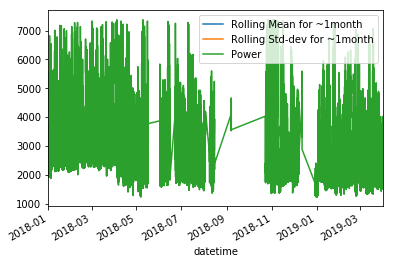

In [9]:
df_processed['power'].rolling(window=60*24*30).mean().plot(label='Rolling Mean for ~1month')
df_processed['power'].rolling(window=60*24*30).std().plot(label='Rolling Std-dev for ~1month')
df_processed['power'].plot(label='Power')
plt.legend()

# Make data stationary

## ACF

d = 1

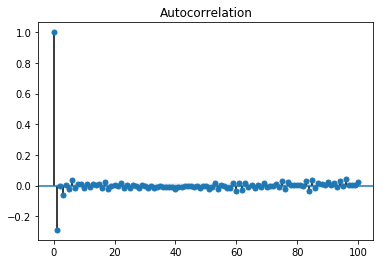

In [10]:
df_diff = df_processed.diff(1).dropna()
fig2 = plot_acf(df_diff, lags=100)

## Add Dickey-Fuller Test

# AR Model

## PACF

We cannot use the ACF plot to determine the p value because it will show good correlations even for the lags which are far in the past, and if we consider those many features, we will have multicollinearity issues. This is not a problem with PACF plot as it removes components already explained by earlier lags, so we only get the lags which have the correlation with the residual i.e the component not explained by earlier lags.

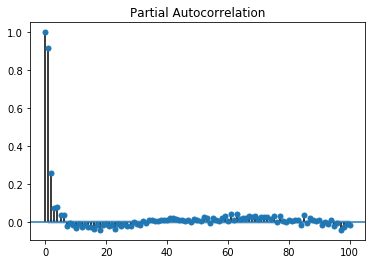

In [11]:
fig3 = plot_pacf(df_processed['power'], lags=100)

# Grid Search ARIMA

In [12]:
train_size = int(0.8 * df_processed['power'].shape[0])
train = df_processed['power'][:-train_size]
test  = df_processed['power'][train_size:]

In [13]:
import itertools
p = d = q = range(0, 5)
pdq = list(itertools.product(p, d, q))

In [14]:
results = {}

for param in pdq:
    try:
        model_arima = ARIMA(train, order=param)
        model_arima_fit = model_arima.fit()
        results[str(param)] = model_arima_fit.aic
        print(param, model_arima_fit.aic)
    except:
        continue

(0, 0, 0) 101724.97104220327
(0, 0, 1) 96250.62169069803
(0, 0, 2) 93627.59477725094
(0, 0, 3) 92167.83011267107
(0, 0, 4) 91342.75925959102
(0, 1, 0) 89147.99938850965
(0, 1, 1) 88978.03550043426
(0, 1, 2) 88850.63219376988
(0, 1, 3) 88848.85920212447
(0, 1, 4) 88850.82909646397
(0, 2, 0) 94038.12000031653
(0, 2, 1) 89144.68538284983
(1, 0, 0) 88984.81323541293
(1, 0, 1) 88877.96225108166
(1, 0, 2) 88784.16504480017
(1, 0, 3) 88785.03312033314
(1, 0, 4) 88786.18936235219
(1, 1, 0) 89029.87166191713
(1, 1, 1) 88870.872425395
(1, 1, 2) 88849.28120985156
(1, 1, 3) 88850.85102927298
(1, 1, 4) 88839.31041383851
(1, 2, 0) 92284.14891683545
(1, 2, 4) 88847.98799618577
(2, 0, 0) 88908.06937496606
(2, 0, 1) 88807.1718770221
(2, 0, 2) 88785.25370660535
(2, 0, 3) 88723.45275271684
(2, 1, 0) 88894.66274909038
(2, 1, 1) 88847.18060454394
(2, 1, 2) 88837.5452359273
(2, 1, 3) 88834.34578979705
(2, 1, 4) 88836.22715348337
(2, 2, 0) 91289.79519649844
(2, 2, 3) 88834.98130064685
(2, 2, 4) 88832.4597042